In [181]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")


# Load the saved model
xgb_model = joblib.load('models/TDS-PART1-MODEL.pkl')

# Load the same dataset to ensure consistency
dtf = pd.read_csv('data/cleaned_data.csv')



In [182]:
dtf.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28,18,3916,34500


In [183]:
# Select numerical columns correctly
numerical_columns = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# Calculate skewness for each numerical column
skewness = dtf[numerical_columns].skew()
skewed_columns = skewness[skewness.abs() > 0.5].index

print("Skewness of numerical columns:\n", skewness)
print("Skewed numerical columns:\n", skewed_columns)


Skewness of numerical columns:
 engine_hp           1.250906
engine_cylinders    0.908377
highway_mpg         7.759205
city_mpg            7.092352
popularity          1.628805
dtype: float64
Skewed numerical columns:
 Index(['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',
       'popularity'],
      dtype='object')


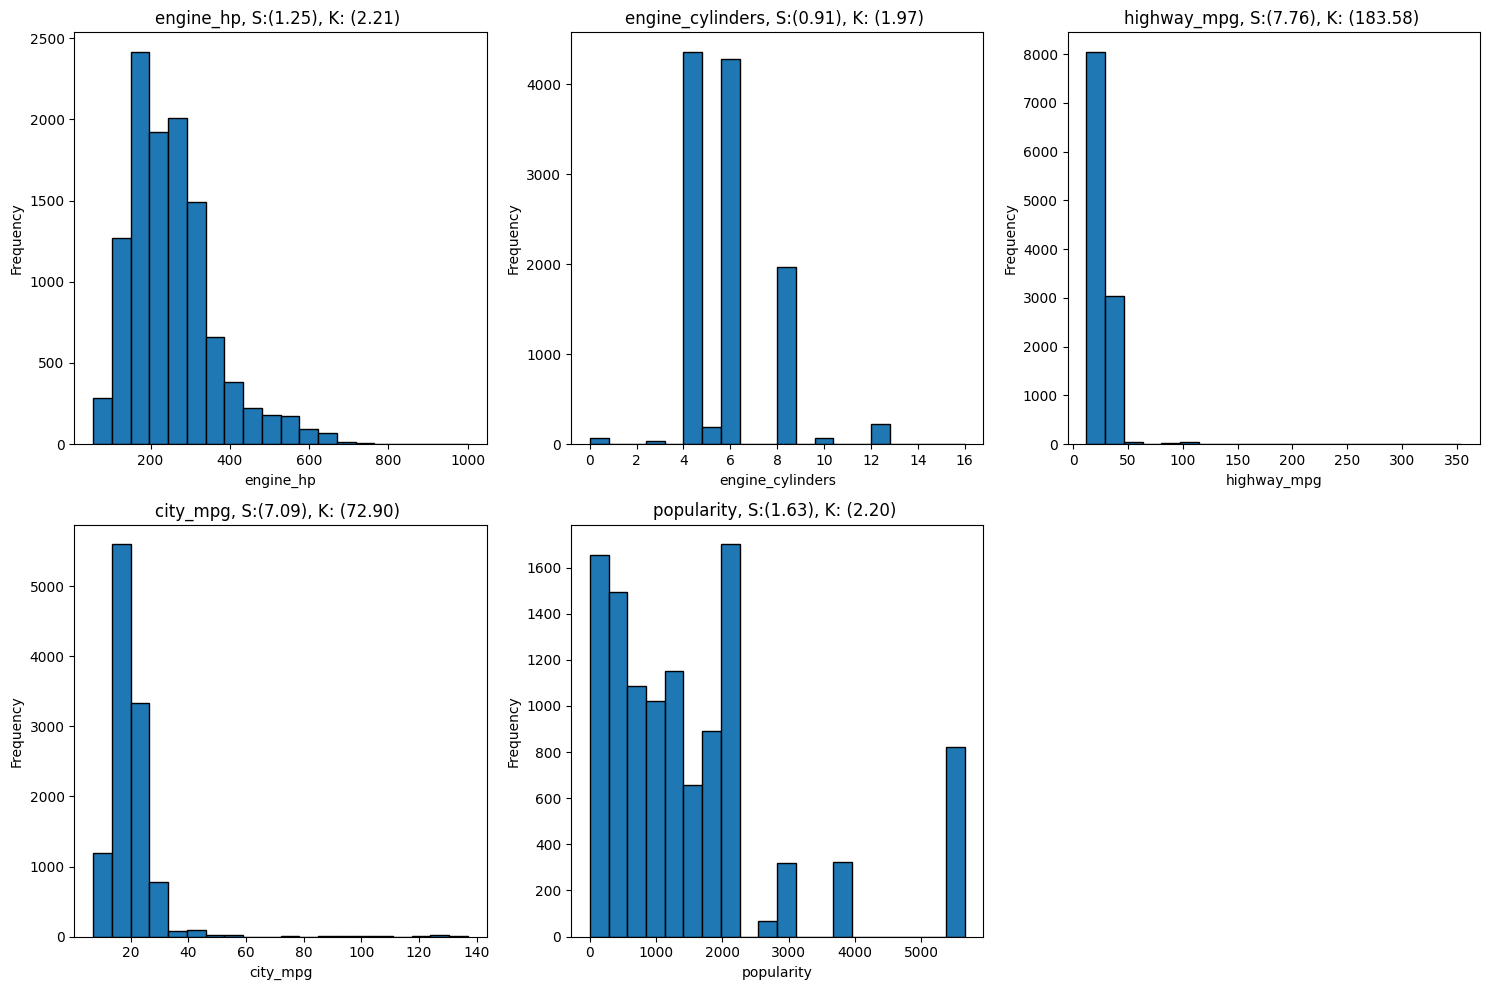

In [184]:
import matplotlib.pyplot as plt
def plot_histograms(numerical_columns):
    num_columns = len(numerical_columns)

    num_rows = int(np.ceil(num_columns / 3))
    num_cols = min(num_columns, 3)

        # create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

    axes = axes.flatten()

        # loop through the columns and plot each histogram
    for i, column in enumerate(numerical_columns):
        axes[i].hist(dtf[column], bins=20, edgecolor='black')
        axes[i].set_title(f"{column}, S:({dtf[column].skew():.2f}), K: ({dtf[column].kurt():.2f}) ")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_histograms(numerical_columns)

Shifting column 'engine_cylinders' by 1.0 to make all values positive.
Box-Cox transformation applied to skewed columns.
Skewness After Box-Cox Transformation:
 engine_hp           0.000253
engine_cylinders    0.132054
highway_mpg        -0.050889
city_mpg           -0.093090
popularity         -0.022833
dtype: float64


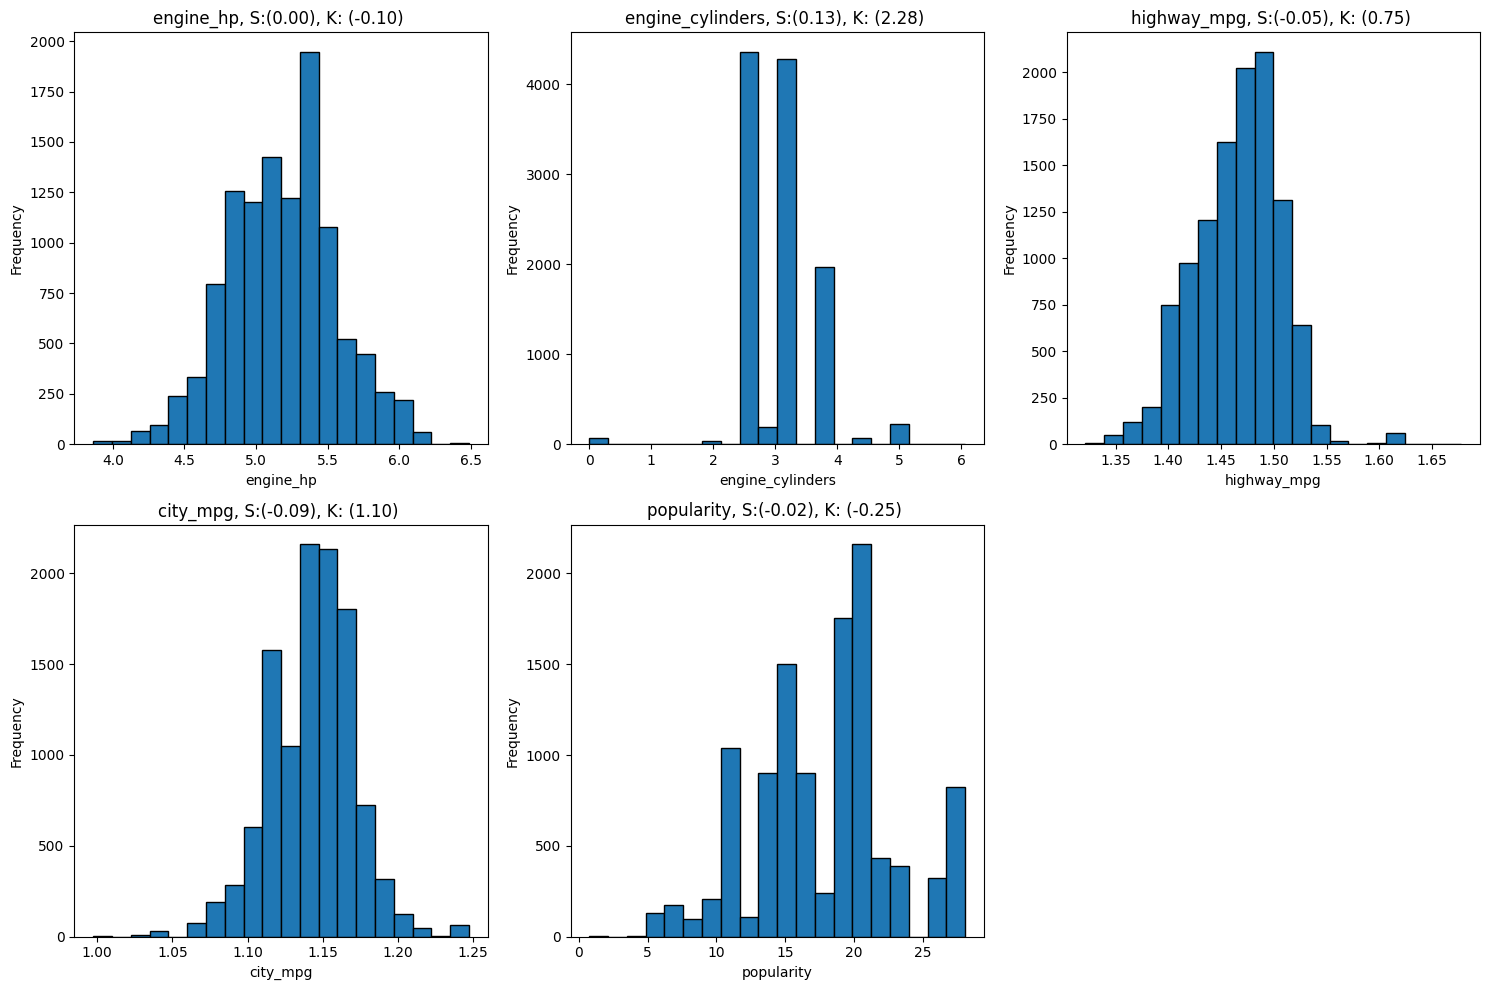

In [185]:
from scipy.stats import boxcox

for col in skewed_columns:
    if (dtf[col] <= 0).any():
        min_val = dtf[col].min()
        shift = abs(min_val) + 1  # Ensure all values are positive
        print(f"Shifting column '{col}' by {shift} to make all values positive.")
        dtf[col] += shift

# Step 3: Apply Box-Cox transformation
boxcox_lambdas = {}  # Dictionary to store lambda values for each column
for col in skewed_columns:
    # Apply Box-Cox transformation
    dtf[col], lmbda = boxcox(dtf[col])
    boxcox_lambdas[col] = lmbda  # Store lambda for each column

print("Box-Cox transformation applied to skewed columns.")

# Step 4: Verify skewness after transformation
new_skewness = dtf[skewed_columns].skew()
print("Skewness After Box-Cox Transformation:\n", new_skewness)

plot_histograms(numerical_columns)


In [186]:
dtf.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),5.514099,3.227848,MANUAL,rear wheel drive,2.0,Compact,Coupe,1.470705,1.147653,25.416292,46135
1,BMW,1 Series,2011,premium unleaded (required),5.414839,3.227848,MANUAL,rear wheel drive,2.0,Compact,Convertible,1.481821,1.147653,25.416292,40650
2,BMW,1 Series,2011,premium unleaded (required),5.414839,3.227848,MANUAL,rear wheel drive,2.0,Compact,Coupe,1.481821,1.152637,25.416292,36350
3,BMW,1 Series,2011,premium unleaded (required),5.175008,3.227848,MANUAL,rear wheel drive,2.0,Compact,Coupe,1.481821,1.142178,25.416292,29450
4,BMW,1 Series,2011,premium unleaded (required),5.175008,3.227848,MANUAL,rear wheel drive,2.0,Compact,Convertible,1.481821,1.142178,25.416292,34500


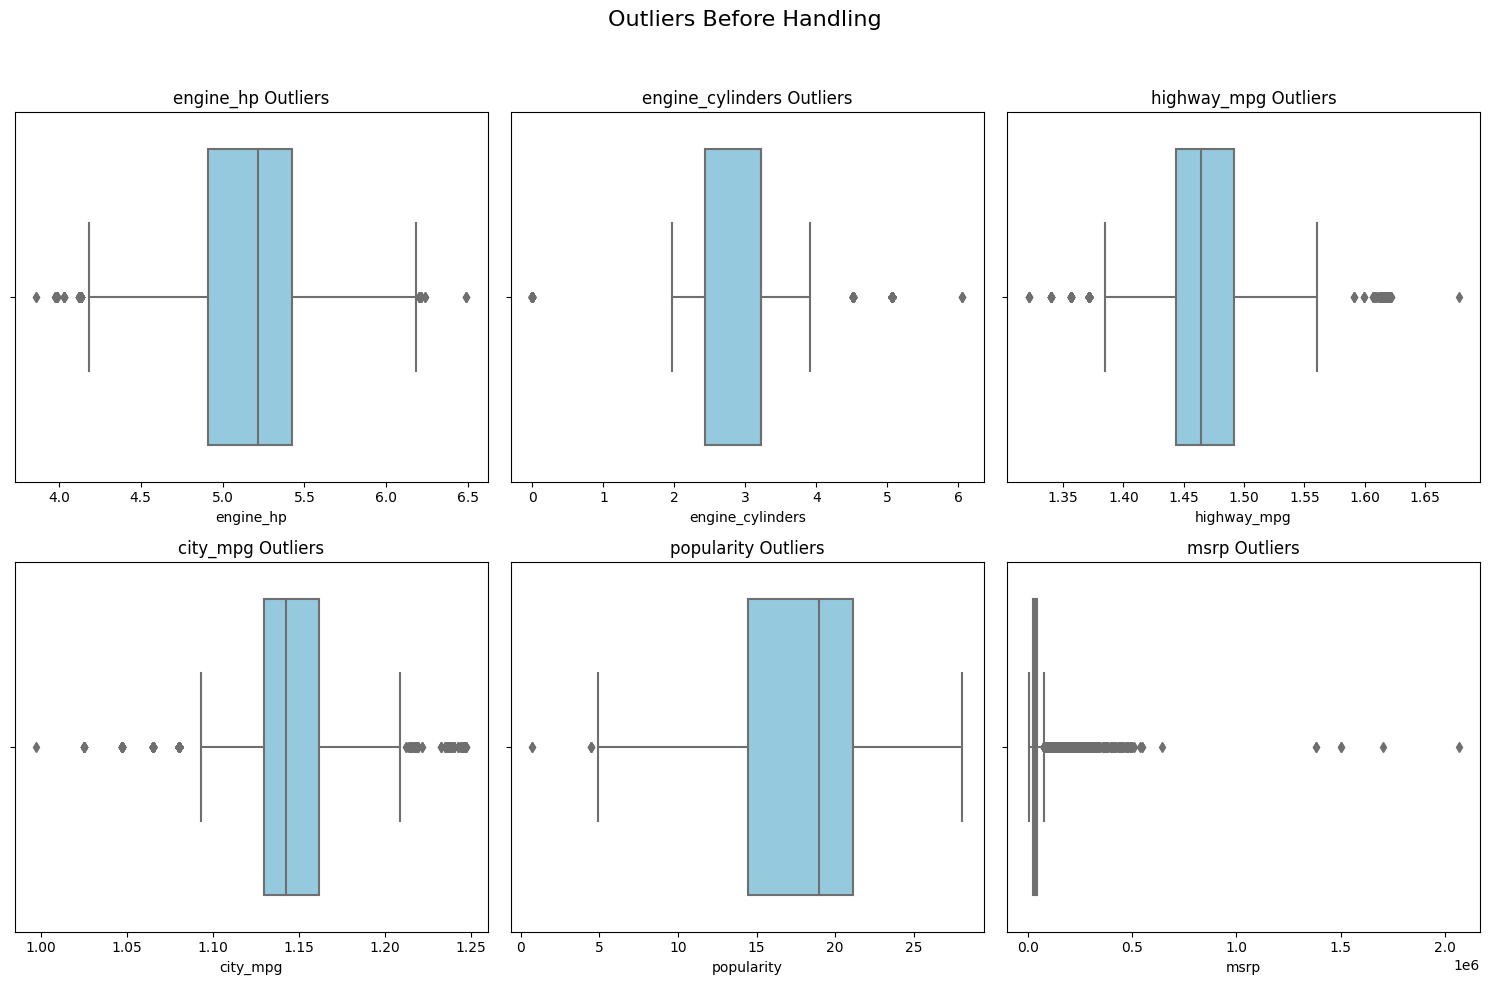

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_outliers(dtf, numerical_columns, title):
    """
    Visualizes outliers in the numerical columns using boxplots in a grid layout.

    Args:
        dtf: DataFrame containing the data.
        numerical_columns: List of numerical columns to plot.
        title: Title of the plot.
    """
    num_columns = len(numerical_columns)
    num_rows = int(np.ceil(num_columns / 3))
    num_cols = min(num_columns, 3)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = axes.flatten()

    # Plot each column in the grid
    for i, col in enumerate(numerical_columns):
        sns.boxplot(data=dtf, x=col, ax=axes[i], color='skyblue')
        axes[i].set_title(f"{col} Outliers")

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Add a main title and adjust layout
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

before_dtf = dtf.copy()
numerical_columns_with_msrp = numerical_columns + ['msrp']
visualize_outliers(before_dtf, numerical_columns_with_msrp, "Outliers Before Handling")


Visualizing distributions after handling outliers...
Number of samples filtered by IQR: -1316
Number of samples in dataset after IQR: 9878


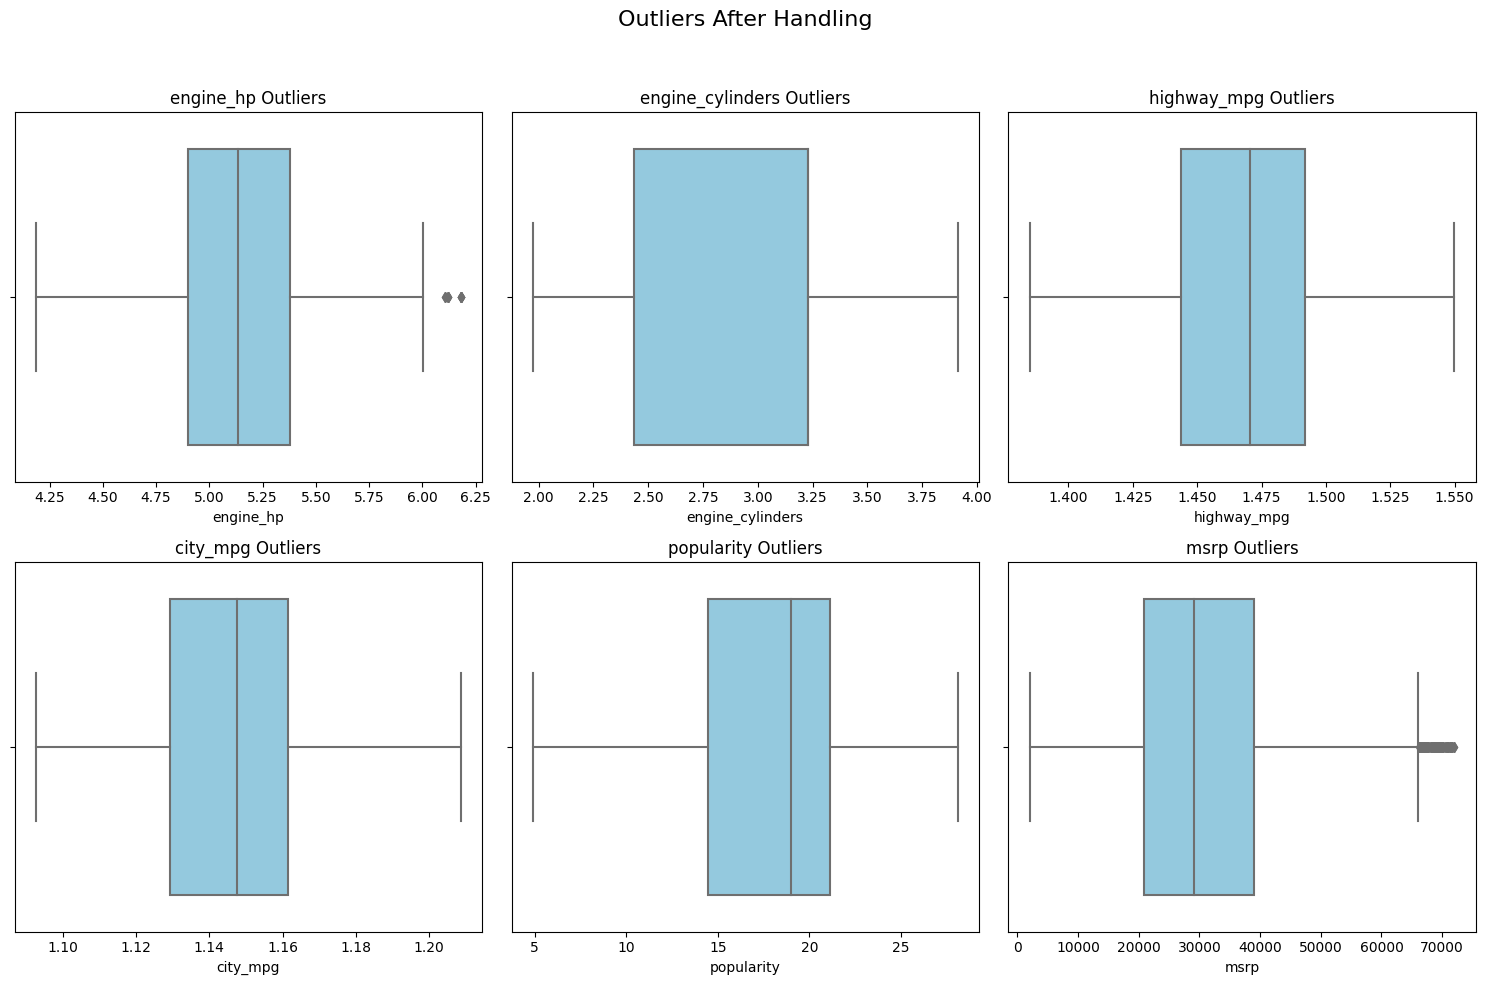

In [188]:
for col in numerical_columns_with_msrp:
    Q1 = dtf[col].quantile(0.25)  # First quartile (25th percentile)
    Q3 = dtf[col].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1                 # Interquartile range

    lower_bound = Q1 - 1.5 * IQR  # Lower bound
    upper_bound = Q3 + 1.5 * IQR  # Upper bound

        # Remove outliers outside the bounds
    dtf = dtf[(dtf[col] >= lower_bound) & (dtf[col] <= upper_bound)]

    # Visualize distributions after handling outliers
print("Visualizing distributions after handling outliers...")
print('Number of samples filtered by IQR: {}'.format(len(dtf) - len(before_dtf)))
print('Number of samples in dataset after IQR: {}'.format(len(dtf)))
visualize_outliers(dtf, numerical_columns_with_msrp, "Outliers After Handling")

In [189]:
dtf.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),5.514099,3.227848,MANUAL,rear wheel drive,2.0,Compact,Coupe,1.470705,1.147653,25.416292,46135
1,BMW,1 Series,2011,premium unleaded (required),5.414839,3.227848,MANUAL,rear wheel drive,2.0,Compact,Convertible,1.481821,1.147653,25.416292,40650
2,BMW,1 Series,2011,premium unleaded (required),5.414839,3.227848,MANUAL,rear wheel drive,2.0,Compact,Coupe,1.481821,1.152637,25.416292,36350
3,BMW,1 Series,2011,premium unleaded (required),5.175008,3.227848,MANUAL,rear wheel drive,2.0,Compact,Coupe,1.481821,1.142178,25.416292,29450
4,BMW,1 Series,2011,premium unleaded (required),5.175008,3.227848,MANUAL,rear wheel drive,2.0,Compact,Convertible,1.481821,1.142178,25.416292,34500


In [190]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Specify target and features
X = dtf.drop(columns=['msrp'])  # Replace 'msrp' with your target column
y = dtf['msrp']

# Detect and encode categorical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a new XGBRegressor model
new_model = xgb.XGBRegressor(random_state=42)
new_model.fit(X_train, y_train)

# Make predictions
y_pred = new_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"New Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

New Model Performance:
MAE: 2289.69
MSE: 9762334.69
RMSE: 3124.47
R²: 0.96


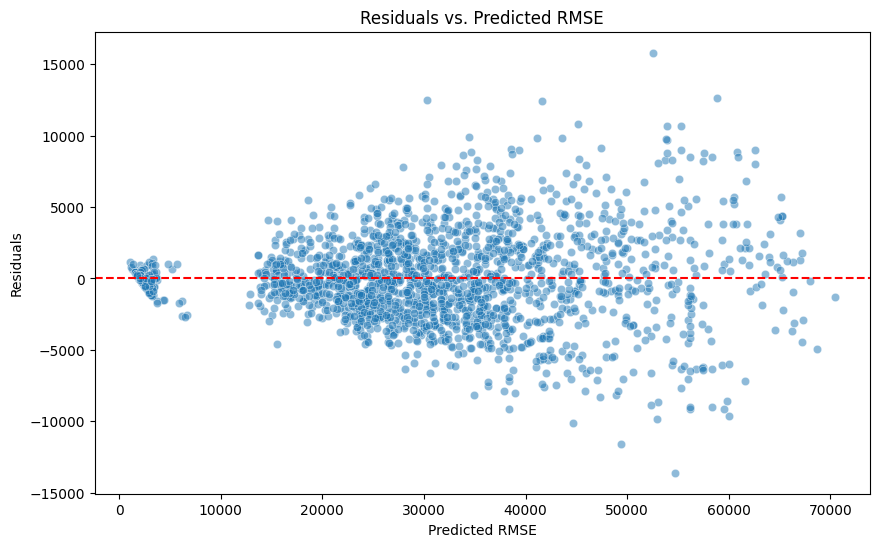

In [191]:
# Calculating residuals
residuals = y_test - y_pred

# Residuals vs. Predicted Exam Scores
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted RMSE')
plt.xlabel('Predicted RMSE')
plt.ylabel('Residuals')
plt.show()

In [192]:
# Calculate absolute errors
errors = np.abs(y_test - y_pred)

# Add results to a DataFrame for easier analysis
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': errors
}).reset_index(drop=True)

# Find the worst and best predictions
worst_predictions = results_df.sort_values(by='Error', ascending=False).head(10)
best_predictions = results_df.sort_values(by='Error', ascending=True).head(10)

print("Worst Predictions:")
print(worst_predictions)

print("\nBest Predictions:")
print(best_predictions)


Worst Predictions:
      Actual     Predicted         Error
1960   68400  52590.914062  15809.085938
637    41135  54736.210938  13601.210938
288    71450  58834.304688  12615.695312
942    42870  30352.001953  12517.998047
885    54025  41607.652344  12417.347656
1954   37815  49405.195312  11590.195312
745    55970  45162.074219  10807.925781
1685   65957  55265.207031  10691.792969
558    64550  53873.554688  10676.445312
1038   34550  44658.773438  10108.773438

Best Predictions:
      Actual     Predicted     Error
1928    3229   3231.793457  2.793457
788     2320   2324.013672  4.013672
790    25305  25299.341797  5.658203
1418    2000   1992.617554  7.382446
1813    3470   3478.895996  8.895996
1003    2000   1990.674194  9.325806
218     2000   1990.674194  9.325806
1145    2000   1990.674194  9.325806
1008    2000   1990.674194  9.325806
1425    2000   1990.674194  9.325806
